In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [6]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

/tmp/ipykernel_148346/4282809631.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-20 17:12:26.002613: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 17:12:26.043695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 17:12:26.043738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugi

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
!wget 'cdn.daitan.com/dataset.zip'

In [ ]:
dataset_file_name = './dataset.zip'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [ ]:
path_to_dataset = "./dataset/tfrecords"

In [ ]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

In [9]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [ ]:
mozilla_basepath = "./dataset/en"
UrbanSound8K_basepath = './dataset/UrbanSound8K'

## Prepare Input features

In [ ]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [ ]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

## Model Training

In [ ]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [ ]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [ ]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [ ]:
def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [ ]:
model = build_model(l2_strength=0.0)
model.summary()

In [ ]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
%tensorboard --logdir logs

In [ ]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

In [ ]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=600, # you might need to change this
         validation_data=test_dataset,
         epochs=400,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

In [ ]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

## Testing

In [1]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [13]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.windows.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [7]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_en_16526.mp3'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

NameError: name 'mozilla_basepath' is not defined

In [ ]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

In [14]:
cleanAudio, sr = read_audio('./audio_sample/Noisy_Input.wav', sample_rate=fs)

cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 4.6129526e-07 Max: 6.2642474


In [ ]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [32]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(noisySTFT)
    plt.title("Noisy sTFT")
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [33]:
#Erase
noisyAudio = cleanAudio
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

plt.figure(figsize=(10,10))
plt.pcolormesh(noise_stft_features)
plt.title("Specetogramme")

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 1645)


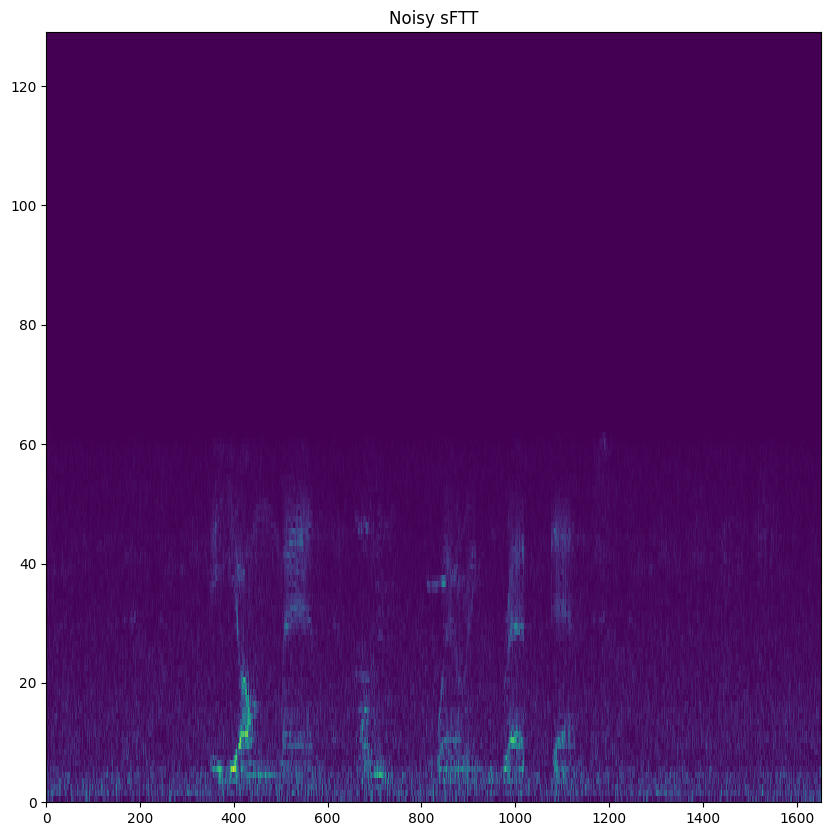

In [34]:
predictors = prepare_input_features(noise_stft_features)

In [20]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (1645, 129, 8, 1)


In [ ]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

In [ ]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [ ]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

In [ ]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")